# Validation Notebook using Iwabuchi et al. 2009

- see: Iwabuchi, H., & Suzuki, T. (2009). Fast and accurate radiance calculations using truncation approximation for anisotropic scattering phase functions. Journal of Quantitative Spectroscopy and Radiative Transfer, 110(17), 1926-1939.

In [ ]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from scipy.integrate import simpson, trapezoid
from pytrunc.phase import calc_moments
from pytrunc.truncation import delta_m_phase_approx, gt_phase_approx
from pytrunc.utils import integrate_lobatto

import matplotlib.pyplot as plt
import xarray as xr

save_fig = False

## Truncation approximation for the anisotropic phase function

### Get realistic water cloud phase function from mie calculation

wav=498.6099853515625 nm ; reff=8.0 um


Text(0, 0.5, 'Phase function []')

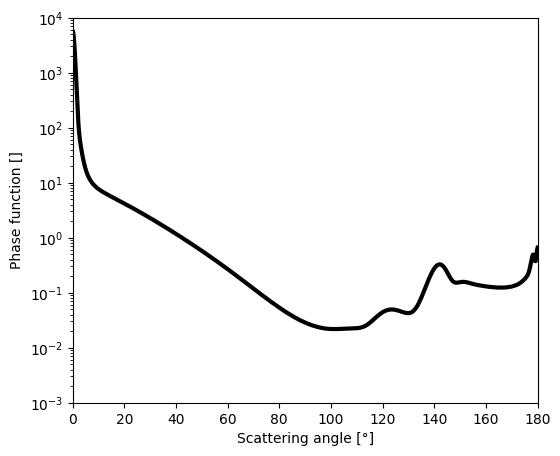

In [13]:
# wc available in smartg auxdata: https://github.com/hygeos/smartg
# Follow smartg README to download auxdata, 
# then create environemnt variable 'SMARTG_DIR_AUXDATA' where auxdata have been downloaded
wc_path = Path(os.environ['SMARTG_DIR_AUXDATA']) / Path('clouds/wc_sol.nc')
ds = xr.open_dataset(wc_path)
# in the paper (Iwabuchi et al. 2009) wl = 500 nm and reff = 8 um
iwav = 49 # iwabuchi
ireff = 3 # iwabuchi
print(f"wav={ds.wav.values[iwav]} nm ; reff={ds.reff.values[ireff]} um")
theta = ds['theta'].values
pha_exact = ds["phase"][ireff,iwav,0,:].values

method = 'lobatto'
# method = 'trapezoid'
# method = 'simpson' # use pair number for theta

INTEGRATORS = {
    "simpson": simpson,
    "trapezoid": trapezoid,
    "lobatto": integrate_lobatto
    }
integrate_m = INTEGRATORS[method]

# theta = np.linspace(0., 180., 18000)
# pha_exact = np.interp(theta, ds.theta.values, pha_exact)

# theta, _ = quadrature_lobatto(0., 180., 7201)
# pha_exact = np.interp(theta, ds.theta.values, pha_exact)

mu = np.cos(np.deg2rad(theta))
idmu = np.argsort(mu)
# renormalize depending on the chosen integration method
if method == 'lobatto':
    sin_th = np.sin(np.deg2rad(theta))
    pha_exact = (2. * pha_exact) / integrate_m(pha_exact*sin_th, np.deg2rad(theta))
else:
    pha_exact = (2. * pha_exact) / integrate_m(pha_exact[idmu], mu[idmu])

plt.figure(figsize=(6,5))
plt.plot(theta, pha_exact, c='k', lw=3)
plt.yscale('log')
plt.ylim(ymin=1e-3, ymax=1e4)
plt.xlim(xmin=0, xmax=180)
plt.xlabel('Scattering angle [°]')
plt.ylabel('Phase function []')

### Plot exact and approximated phase functions
 - Reproduce Fig.1a

integral(P_exact)= 2.0
integral(P_approx)= 2.0000672337198964
f = 0.4331414968663314


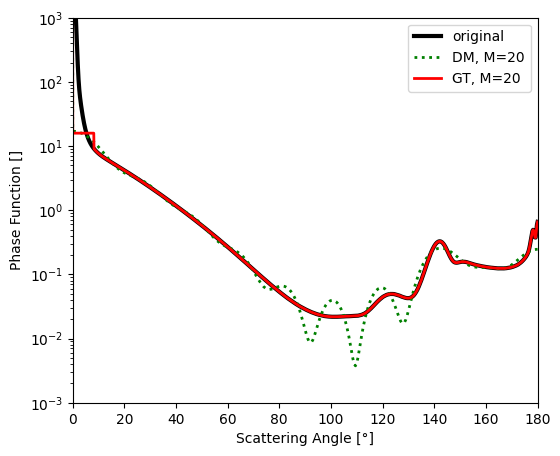

In [14]:
m_max = 20
pha_approx, f, pha_star, chi_star = delta_m_phase_approx(pha_exact, theta, m_max, method=method)
pha_approx_gt, f_gt, pha_star_gt = gt_phase_approx(pha_exact, theta, f, method=method, th_tol=12)

plt.figure(figsize=(6,5))
plt.plot(theta, pha_exact, 'k', lw=3, label='original')
plt.plot(theta, pha_approx, 'g:', lw=2, label=f'DM, M={m_max}')
plt.plot(theta, pha_approx_gt, 'r', lw=2, label=f'GT, M={m_max}')
plt.yscale('log')
plt.ylim(ymin=1e-3, ymax=1e3)
plt.xlim(xmin=0, xmax=180)
plt.legend()
plt.ylabel("Phase Function []")
plt.xlabel("Scattering Angle [°]")
if save_fig:
    plt.savefig("iwabuchi_fig1a.png", dpi=200)

mu = np.cos(np.deg2rad(theta))
idmu = np.argsort(mu)
if method == 'lobatto':
    print("integral(P_exact)=", integrate_m(pha_exact*np.sin(np.deg2rad(theta)),
                                            np.deg2rad(theta)))
    print("integral(P_approx)=", integrate_m(pha_approx*np.sin(np.deg2rad(theta)), 
                                             np.deg2rad(theta)))
else:
    print("integral(P_exact)=", integrate_m(pha_exact[idmu], mu[idmu]))
    print("integral(P_approx)=", integrate_m(pha_approx[idmu], mu[idmu]))
print("f =",f)

### Zoom of previous plot
- Fig.1b

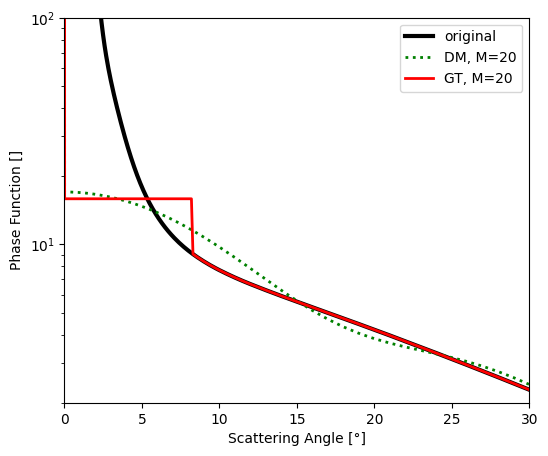

In [15]:
plt.figure(figsize=(6,5))
plt.plot(theta, pha_exact, 'k', lw=3, label='original')
plt.plot(theta, pha_approx, 'g:', lw=2, label=f'DM, M={m_max}')
plt.plot(theta, pha_approx_gt, 'r', lw=2, label=f'GT, M={m_max}')
plt.yscale('log')
plt.ylim(ymin=2, ymax=100)
plt.xlim(xmin=0, xmax=30)
plt.legend()
plt.ylabel("Phase Function []")
plt.xlabel("Scattering Angle [°]")
if save_fig:
    plt.savefig("iwabuchi_fig1b.png", dpi=200)

### Plot exact and approximated phase moments
- Fig.2a

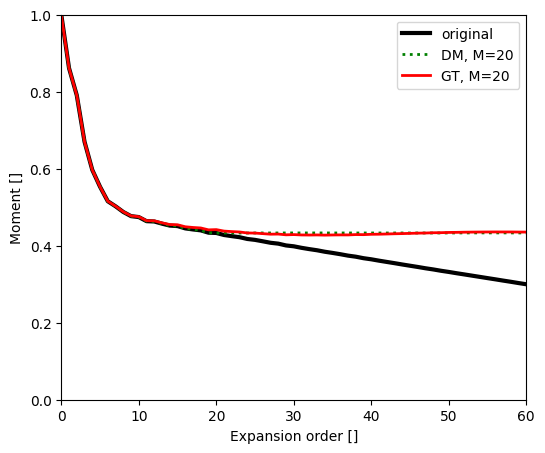

In [16]:
n_expan = 60
chi_exact = calc_moments(phase=pha_exact, theta=theta, m_max=n_expan, method=method, normalize=True)
chi_approx = calc_moments(phase=pha_approx, theta=theta, m_max=n_expan, method=method, normalize=True)
chi_approx_gt = calc_moments(phase=pha_approx_gt, theta=theta, m_max=n_expan, method=method, normalize=True)

exp_order = np.arange(61)
plt.figure(figsize=(6,5))
plt.plot(chi_exact, 'k', lw=3, label='original')
plt.plot(chi_approx, 'g:', lw=2, label=f'DM, M={m_max}')
plt.plot(chi_approx_gt, 'r', lw=2, label=f'GT, M={m_max}')
plt.xlim(xmin=0, xmax = 60)
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.ylabel("Moment []")
plt.xlabel("Expansion order []")
if save_fig:
    plt.savefig("iwabuchi_fig2a.png", dpi=200)

### Plot moment ratio
- Fig.2b

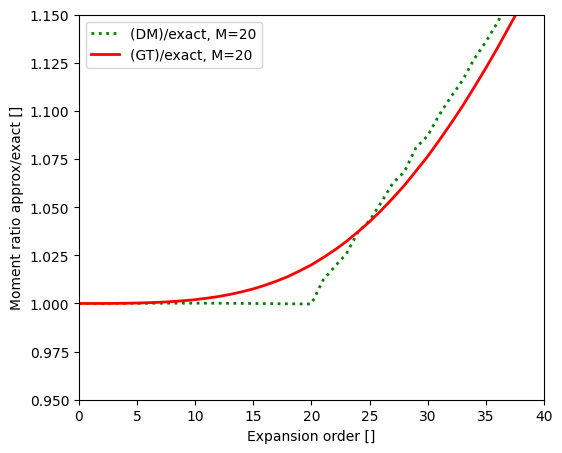

In [17]:
exp_order = np.arange(61)
plt.figure(figsize=(6,5))
plt.plot(chi_approx/chi_exact, 'g:', lw=2, label=f'(DM)/exact, M={m_max}')
plt.plot(chi_approx_gt/chi_exact, 'r', lw=2, label=f'(GT)/exact, M={m_max}')
plt.xlim(xmin=0, xmax = 40)
plt.ylim(ymin=0.95, ymax=1.15)
plt.legend()
plt.ylabel("Moment ratio approx/exact []")
plt.xlabel("Expansion order []")
if save_fig:
    plt.savefig("iwabuchi_fig2b.png", dpi=200)